In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, desc
import matplotlib.pyplot as plt
import seaborn as sns

## Big Processing Data

In [2]:
# Initialize Spark Session
spark = SparkSession.builder.appName("AdvancedEDA").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/04 00:09:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/04 00:10:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/01/04 00:10:00 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [6]:
# Load datasets
fact_sales = spark.read.csv("Dataset/FactInternetSales.csv", header=True, inferSchema=True)
dim_customer = spark.read.csv("Dataset/DimCustomer.csv", header=True, inferSchema=True)
dim_product = spark.read.csv("Dataset/DimProduct.csv", header=True, inferSchema=True)
dim_date = spark.read.csv("Dataset/DimDate.csv", header=True, inferSchema=True)
dim_sales_territory = spark.read.csv("Dataset/DimSalesTerritory.csv", header=True, inferSchema=True)


In [7]:
# Cache datasets for performance
fact_sales.cache()
dim_customer.cache()
dim_product.cache()
dim_date.cache()
dim_sales_territory.cache()


25/01/04 00:12:09 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[SalesTerritoryKey: int, SalesTerritoryAlternateKey: int, SalesTerritoryRegion: string, SalesTerritoryCountry: string, SalesTerritoryGroup: string]

In [8]:
# Register DataFrames as SQL temporary views
fact_sales.createOrReplaceTempView("FactInternetSales")
dim_customer.createOrReplaceTempView("DimCustomer")
dim_product.createOrReplaceTempView("DimProduct")
dim_date.createOrReplaceTempView("DimDate")
dim_sales_territory.createOrReplaceTempView("DimSalesTerritory")


In [9]:
# Step 1: Total Sales by Product
total_sales_by_product = spark.sql("""
    SELECT dp.EnglishProductName, SUM(fs.SalesAmount) AS TotalSales
    FROM FactInternetSales fs
    JOIN DimProduct dp ON fs.ProductKey = dp.ProductKey
    GROUP BY dp.EnglishProductName
    ORDER BY TotalSales DESC
    LIMIT 10
""")
total_sales_by_product.show()


+--------------------+------------------+
|  EnglishProductName|        TotalSales|
+--------------------+------------------+
|Mountain-200 Blac...|1373469.5481999982|
|Mountain-200 Blac...| 1363142.093399998|
|Mountain-200 Silv...| 1339462.790399998|
|Mountain-200 Silv...|1301100.0983999984|
|Mountain-200 Blac...| 1294866.141199998|
|Mountain-200 Silv...| 1257434.572799998|
|    Road-150 Red, 48|1205876.9900000044|
|    Road-150 Red, 62|1202298.7200000044|
|    Road-150 Red, 52|1080637.5400000038|
|    Road-150 Red, 56|1055589.6500000036|
+--------------------+------------------+



In [10]:
# Step 2: Monthly Sales Trend
monthly_sales_trend = spark.sql("""
    SELECT dd.CalendarYear, dd.EnglishMonthName, SUM(fs.SalesAmount) AS MonthlySales
    FROM FactInternetSales fs
    JOIN DimDate dd ON fs.OrderDateKey = dd.DateKey
    GROUP BY dd.CalendarYear, dd.EnglishMonthName
    ORDER BY dd.CalendarYear, dd.EnglishMonthName
""")
monthly_sales_trend.show()


+------------+----------------+-----------------+
|CalendarYear|EnglishMonthName|     MonthlySales|
+------------+----------------+-----------------+
|        2010|        December|43421.03639999999|
+------------+----------------+-----------------+



In [11]:
# Step 3: Top 5 Regions by Sales
top_regions = spark.sql("""
    SELECT dst.SalesTerritoryRegion, SUM(fs.SalesAmount) AS RegionalSales
    FROM FactInternetSales fs
    JOIN DimSalesTerritory dst ON fs.SalesTerritoryKey = dst.SalesTerritoryKey
    GROUP BY dst.SalesTerritoryRegion
    ORDER BY RegionalSales DESC
    LIMIT 5
""")
top_regions.show()

+--------------------+------------------+
|SalesTerritoryRegion|     RegionalSales|
+--------------------+------------------+
|           Australia| 9061000.584400563|
|           Southwest| 5718150.812200519|
|           Northwest|3649866.5511999447|
|      United Kingdom|3391712.2108999686|
|             Germany| 2894312.338199975|
+--------------------+------------------+



In [12]:
# Step 4: Customer Segmentation by Income and Sales
customer_segmentation = spark.sql("""
    SELECT dc.YearlyIncome, COUNT(fs.CustomerKey) AS CustomerCount, SUM(fs.SalesAmount) AS TotalSales
    FROM FactInternetSales fs
    JOIN DimCustomer dc ON fs.CustomerKey = dc.CustomerKey
    GROUP BY dc.YearlyIncome
    ORDER BY TotalSales DESC
""")
customer_segmentation.show()


+------------+-------------+------------------+
|YearlyIncome|CustomerCount|        TotalSales|
+------------+-------------+------------------+
|       70000|         8267| 4484238.823500113|
|       60000|         9470|   4230548.6123004|
|       40000|         9181| 4226593.341500258|
|       30000|         6994| 2922275.194399966|
|       80000|         4848|2391471.6616999786|
|       90000|         3143|2067047.8072999879|
|       20000|         5128|2010650.4830999786|
|       10000|         3352| 1396359.097599991|
|      130000|         1906|1192927.8165999912|
|      100000|         1955|1073018.3033999926|
|      110000|         1715|1019527.5549999941|
|       50000|         1977| 805522.9329999941|
|      120000|         1242| 760616.0878999969|
|      170000|          476|       325285.6955|
|      150000|          385|241470.69370000024|
|      160000|          359| 211123.1142000003|
+------------+-------------+------------------+



In [13]:
# Step 5: Visualize SQL Query Results
# Convert to Pandas for plotting
df_top_regions = top_regions.toPandas()
df_total_sales_by_product = total_sales_by_product.toPandas()


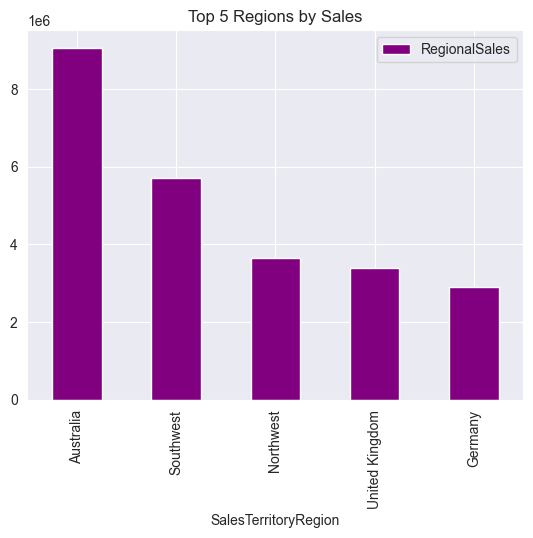

In [14]:
# Bar chart of top regions by sales
df_top_regions.plot(kind="bar", x="SalesTerritoryRegion", y="RegionalSales", color="purple", title="Top 5 Regions by Sales")
plt.show()

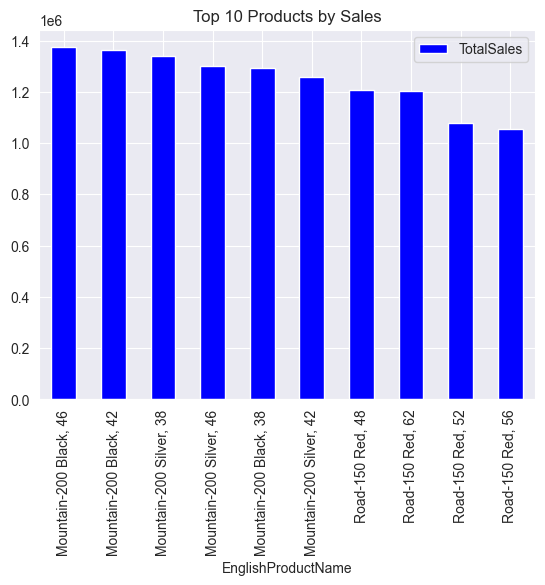

In [15]:
# Bar chart of top products by sales
df_total_sales_by_product.plot(kind="bar", x="EnglishProductName", y="TotalSales", color="blue", title="Top 10 Products by Sales")
plt.show()

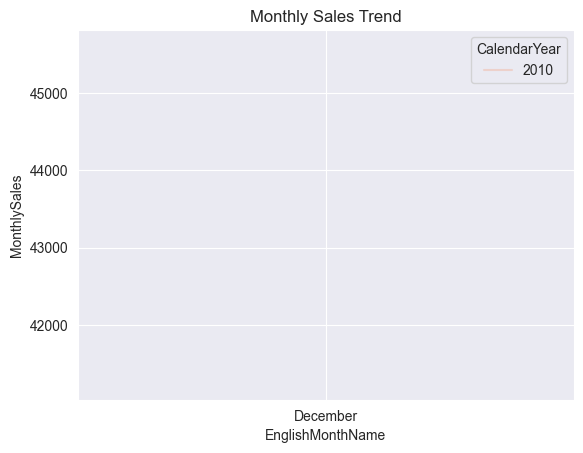

In [16]:
# Scatter plot of Monthly Sales Trend
monthly_sales_trend_pandas = monthly_sales_trend.toPandas()
sns.lineplot(data=monthly_sales_trend_pandas, x="EnglishMonthName", y="MonthlySales", hue="CalendarYear")
plt.title("Monthly Sales Trend")
plt.show()

In [17]:
# Clean up
spark.stop()
